# Sound source localization with a microphones array : beamforming approaches

You have characterized and analyzed the sound propagation in the previous practical. We will now
exploit theses properties to infer one sound source position w.r.t.\ a linear microphone array made
of $N=8$ omnidirectional MEMS microphones. The system you will be using is the same as before;
thus, most of the code you already wrote to acquire signals, plot them, etc.\ will remain the same.

In all the following, the acquisition system will work with a sampling frequency $F_s = 20$kHz, and with a buffer of size $\texttt{BLK} = 2048$.

In [1]:
# All required import
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from client import array
import time
from utils import *
# %matplotlib notebook
%matplotlib ipympl

In [2]:
# antenne=array('server') # When performing real-time acquisition
# mu32 has a problem and we have to reestart the kernel every time we load a file 

# On load l'antenne ici pour pouvoir avoir les attributs tels que Fs
antenne = load_antenne("Enregistrements/turning_record.h5") # Same as array('play') without usign the gui

#Les autres enregistrements sont au format npz puisqu'on avait besoin que d'un seul buffer pour ceux ci

{'Enregistrements/turning_record.h5': {'analogs': array([], dtype=float64), 'analogs_number': 0, 'channels_number': 8, 'comment': '', 'compression': False, 'counter': False, 'counter_skip': False, 'dataset_duration': 1, 'dataset_length': 20000, 'dataset_number': 8, 'datatype': 'int32', 'date': '2022-11-21 17:26:59.494968', 'duration': 8, 'mems': array([ 8,  9, 10, 11, 12, 13, 14, 15]), 'mems_number': 8, 'sampling_frequency': 20000.0, 'timestamp': 1669048019.494968}}


In [3]:
# Load acquisition and array parameters from the antenne variable, after launching acquisition or play
Fs = antenne.fs
BLK = antenne.blocksize
N = antenne.mems_nb
d = antenne.interspace

### 1) To begin, start the acquisition of the audio system, and capture one audio buffer. Plot the resulting signals as a function of time.

In [4]:

#  antenne=array('play')   # When playing recorded files

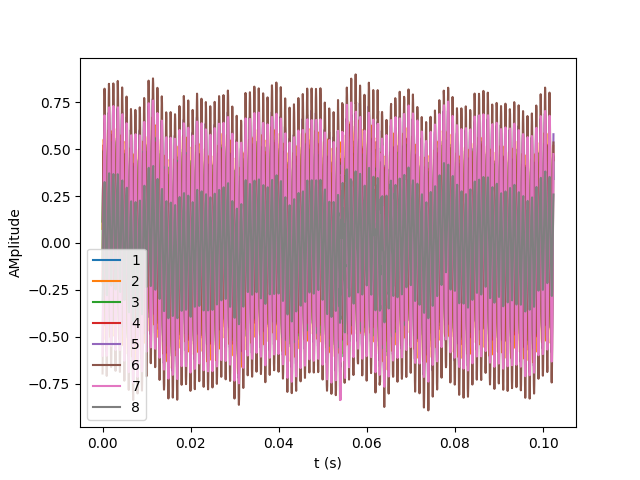

In [5]:

m = np.load("Enregistrements/1000hz_29_27.npy")
# Read an audio buffer
t = [i/Fs for i in range(m.shape[1])]

plt.figure()
for i in range(len(m)):
    plt.plot(t, m[i], label = i+1)
plt.xlabel("t (s)")
plt.ylabel("AMplitude")
plt.legend()


## 2.1/ Coding the beamformer filters and analyzing their properties

**These first questions have to be prepared before the practical session**

### 2) Write the position $z_n$ as a function of $n$ and interspace $d$. As a convention, the first microphone number is selected as $0$.

One can write :
$$z_n = d\times(n - \frac{N+1}{2})$$

### 3) Propose a function **beam_filter** returning the filter frequency response for one microphone number **mic_nb**. 

In [6]:
def beam_filter(array, freq_vector, theta0=0, mic_nb: int = 0):
    """Compute the filter frequency response of a DSB beamformer for one microphone

    Args:
        array (array_server obj): array structure controlling the acquisition system.
        freq_vector (np.array): frequency vector. 
        theta0 (int, optional): focusing angular direction (in degrees). Defaults to 0.
        mic_id (int, optional): microphone id. Defaults to 0.

    Returns:
        np.array: the filter frequency response. Shape is (len(freq_vector),).
    """

    N = array.mems_nb
    d = array.interspace
    # Microphone position x
    # z = d*(mic_nb - (N+1/2))
    z =(mic_nb -N -1 )/2 *d
    # Filter's frequency response
    W = np.exp(-1j*2*np.pi* (freq_vector/340) *z*np.cos(theta0 * np.pi/180))
    return W

### 4) Plot the two frequency responses obtained for two filters associated to two different microphone outputs when $\theta_0=0^\circ$ and for frequencies between $0$ and 5kHz. Explain the effect of these filters on the signals.

/home/huss/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


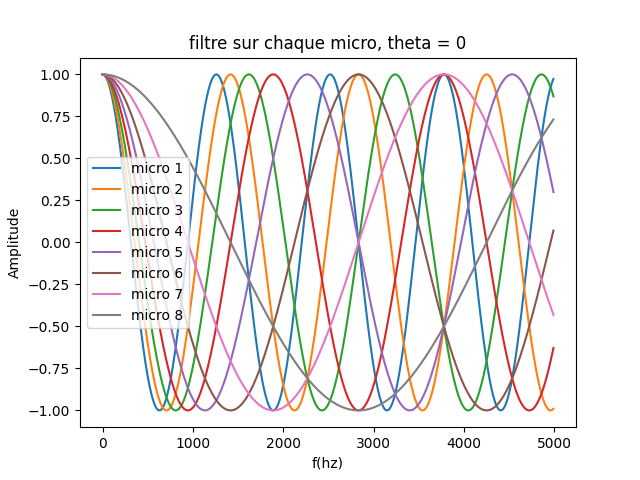

In [7]:
F = np.arange(0, 5000, Fs/BLK)
plt.figure()
for i in range(N):
    W90 = beam_filter(antenne, F, 0, i)
    plt.plot(F, W90, label = f"micro {i+1}")
plt.title("filtre sur chaque micro, theta = 0")
plt.xlabel("f(hz)")
plt.legend()
plt.ylabel("Amplitude")
plt.show()

Ces filtres, une fois appliqué aux microphones, ajoutent un retard fonction de $\theta _0$.
En fonction du retard, lors de la sommation, on peut avoir des ondes destructive ce qui va permettre nottement de selectionner une plage de theta pour lequelle le array laisse passer le son.

### 5) Compare again the filters obtained when $\theta_0 = 90^\circ$. Explain the differences.

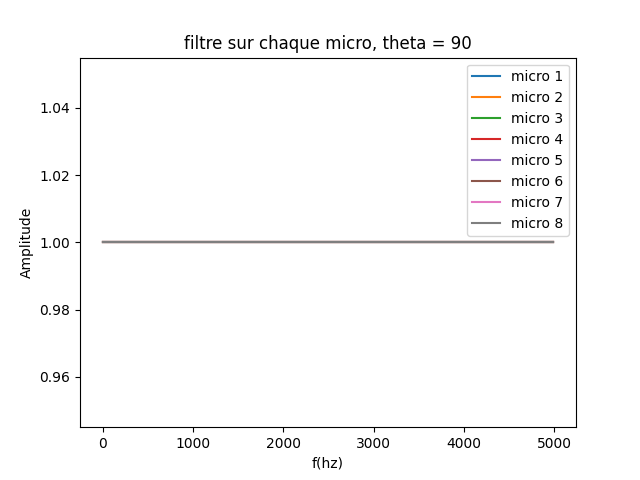

In [8]:
F = np.arange(0, 5000, Fs/BLK)
plt.figure()
for i in range(N):
    W90 = beam_filter(antenne, F, 90, i)
    plt.plot(F, W90, label = f"micro {i+1}")
plt.title("filtre sur chaque micro, theta = 90")
plt.xlabel("f(hz)")
plt.legend()
plt.ylabel("Amplitude")
plt.show()

Lorsque $\theta _0$ = 90°, cos(90°) = 0, l'exponentielle vaut 1. </br>
Ainsi chaque filtre sera égal à 1 et n'auront aucun effet sur les micros. </br>
l'effet du beamforming aura lieu lors de la sommation ce chaques micros (dans le domaine fréquentielle) qui selectionnera les angles aux envirions de 90° (et son symétrique) 

## 2.2/ Using the filters : coding of the beamforming
Basically, the beamforming algorithm is the following :

- (a) acquire an audio frame
- (b) compute the corresponding FFT
- (c) analyze the FFT to define which frequency(ies) you would like to localize
- (d) restrict the FFT to the frequencies of interest
- (e) for one given $\theta _0$, for the frequencies selected before, and for each microphone :
  — compute the corresponding filters frequency responses with the beam_filter func-
tion
  — apply these filters to the microphone outputs
- (f) compute the beamformer output associated to the angular polarization ✓ 0
- (g) repeat all these last steps for each ✓ 0 you want to test
- (h) finally, decide of the angular position of the source by detecting for which ✓ 0 the beam-
former output is maximum.

### 6) Step (a) and (b) : After acquiring an audio buffer, compute its FFT in an array $M_{fft}$. Plot the result of this analysis as a function of the frequency when emitting a pure sine tone with a frequency $F_0$ = 1kHz.

In [9]:
# m = antenne.read()
m = np.load("Enregistrements/1000hz_29_27.npy")


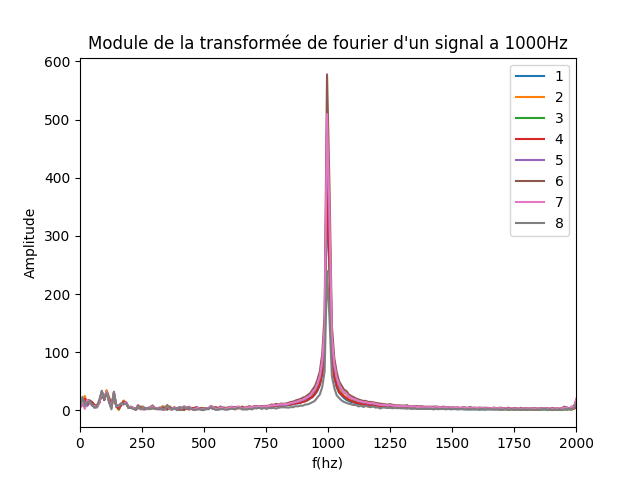

In [10]:
F0 =  1000
Freq  = np.arange(0, Fs, Fs/BLK)
Mfft = np.fft.fft(m)
plt.figure()
for i in range(len(Mfft)):
    plt.plot(Freq, np.abs(Mfft[i]),  label = i+1)
plt.title("Module de la transformée de fourier d'un signal a 1000Hz")
plt.xlabel("f(hz)")
plt.ylabel("Amplitude")

plt.legend()
plt.xlim((0,2000))
plt.show()


Premièrement on observe un pic à 1000Hz pour tous les micros. Cela montre que l'acquisition s'est bien passée. </br>
L'enregistement a été effectué avec un angle theta environ = à 120 degré.</br>
Tous les pics sont à 1000hz, les micros enregistrent le son avec un retard temporel mais ils ont la même fréquence </br>
On voit cependant que l'amplitude varie, par exemple le micro 6 à une amplitude plus forte que le micro 2. </br>
étant donné que la source est proche (pas vraiment a l'infini), le téléphone étant très orienté vers le micro 6 et 7, leur amplitude est plus grande </br>
Cela ne gênera pas le TP


### 7) Step (c) and (d) : Among all the frequencies you obtained from the FFT, select the one corresponding to the source frequency. Give its exact value and index $k_0$ in the frequency array, and collect the corresponding FFT values of each microphone outputs in one vector $\texttt{M}$ of length $N$.

In [11]:

Mfft = np.fft.fft(m)
k0 = (np.argmin(np.abs(Freq - F0)))


print("Frequence a k0", Freq[k0])

M = []
Mft = np.fft.fft(m)
M = Mft[:,k0] 


print("Valeurs de M : ")
print(M)

Frequence a k0 996.09375
Valeurs de M : 
[358.25948655 -57.47344405j 402.98493197-138.26742791j
 334.15537023-195.95272337j 272.11290781-267.42237214j
  65.99645514-483.08203202j -46.09712296-575.70426914j
 -61.12019537-505.79776658j  -2.89491197-239.65662272j]


On  a déteerminé l'indice k0 pour lesquel on observe le pics à 1000hz. Cela correspond à l'étape d) : restrict the FFT to the frequencies of interest </br>
Pourquoi ? : a répondre


### 8) Step (e) : In a loop among all microphones, compute each filters for the position $\theta_0$ and for the frequency value you obtained in the previous step. Apply then these filters to the array $\texttt{M}$ defined before.

In [12]:
W= []
for i in range(N):
    W.append(beam_filter(antenne, Freq[k0], theta0 = 0, mic_nb=i))

W = np.array(W)
YW = W*M
print(YW)

    


[  35.73257224-361.07650125j -249.2940298 -345.49562041j
 -380.13012488 -74.55447272j -313.82579811+216.96434767j
  118.0985547 +473.05022263j  489.87002897+305.92107638j
  509.17664255 -17.49873254j  212.76553414-110.33813852j]


### 9) \textbf{Step (f):} Combine then the filters outputs to form the beamformer output $Y_{\theta_0}[k_0]$. *$Y_{\theta_0}[k_0]$ is obviously a complex value which corresponds to the frequency contribution of the source to the $k_0^{\text{th}}$ frequency component of the beamformer output when focalized in the direction $\theta_0$.* Compute then the corresponding power $P(\theta_0)$ at $k_0$ of the beamformer output.

In [13]:
Y_tet0 = np.sum(YW)

P = np.sum(np.abs(YW))**2

print(Y_tet0)
print(P)

(422.393379807354+86.9721812338984j)
11370713.918065872


On a maintenant la réponse en sortie Y pour k0

### 10) For a direction $\theta_0$ of your choice, compute $P(\theta_0)$ for (i) a source emitting from a direction close to $\theta_0$, or (ii) far from it. Compare the two values.

In [14]:
# theta 0 = 90
W = []
for i in range(N):
    W.append(beam_filter(antenne, Freq[k0], theta0 = 90, mic_nb=i))

YW = M * W


Y_tet90 = np.sum(YW)

P90 = np.abs(Y_tet90)**2

print(f"Y_tet90[k0] vaut :", Y_tet90)
print("La puissance P vaut :", P90)


Y_tet90[k0] vaut : (1323.3969213862933-2463.3566579287112j)
La puissance P vaut : 7819505.435696429


In [15]:
#theta 0 = 0
W = []
for i in range(N):
    W.append(beam_filter(antenne, Freq[k0], theta0 = 0, mic_nb=i))

YW = M * W


Y_tet90 = np.sum(YW)

P0 = np.abs(Y_tet90)**2

print(f"Y_tet90[k0] vaut :", Y_tet90)
print("La puissance P vaut :", P0)



Y_tet90[k0] vaut : (422.393379807354+86.9721812338984j)
La puissance P vaut : 185980.3276136617


La puisance à 90 degré est bien plus grande que la puissance à 0 degré, en effet l'acquisition a été faites aux environs de 120 degrés, on va chercher a trouvé theta 0 pour lequel P est maximum. l'angle 90 degré est bien plus proche du vrai angle, la puissance retoruné par le beamforming est plus gande

### 11) Step (g) : Repeat now the previous code in a loop for $\theta_0$ values ranging from 0 to 180° .You should then obtain an array $\texttt{P}$ where each value corresponds to the power of the beamformer output at $F_0$ for each angular polarization. Plot the array $\texttt{P}$ as a function of the angle $\theta_0$.

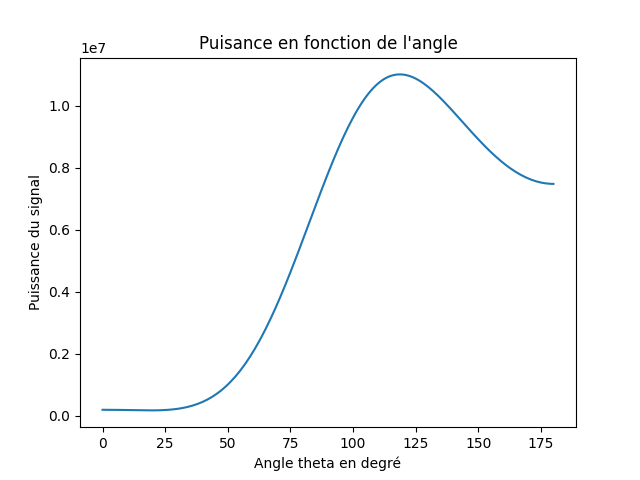

In [16]:
thetas = np.arange(0, 181, 1)
Power = []
for theta in thetas:
    W = []
    for i in range(N):
        W.append(beam_filter(antenne, Freq[k0], theta0 = theta, mic_nb= i))
    YW = M*W
    P = np.abs(np.sum(YW))**2
    Power.append(P)


plt.figure()
plt.plot(list(thetas), Power)
plt.xlabel("Angle theta en degré")
plt.ylabel("Puissance du signal")
plt.title("Puisance en fonction de l'angle")
plt.show()


Le beamforming nous retourne donc bien un maximum aux alentours de 120 degré

### 12) Step (h) : Find the $\theta_0$ value corresponding to position of the maximum in $\texttt{P}$ and compare it with the actual (but approximate) position of the sound source.

In [17]:
print("angle pour lequel la puissance est maximum :", np.argmax(Power))

angle pour lequel la puissance est maximum : 119


Cela correspond aux conditions dans lesquelles a été fait l'acquisisiton, c'est à dire 120 degré environ.

In [18]:
import beamformer_etu as bf
def beamforming(m, thetas, F0 , FS):
    N, BLK = np.shape(m)
    Mfft = np.fft.fft(m)
    Freq = np.arange(0, Fs, Fs/BLK)

    k0 = (np.argmin(np.abs(Freq - F0)))

    #On selectionne pour chaque micro la fréquence d'interet k0
    M = Mfft[:, k0]
    Power = []    
    for theta in thetas:
        W = []
        for i in range(N):
            W.append(beam_filter(antenne, Freq[k0], theta0 = theta, mic_nb= i))

        YW = M*W
        P = np.abs(np.sum(YW))**2
        Power.append(P)
    return Power


## 2.3/ Analyzing the beamformer performances

From now on, you can use your own code written in Section 2.2, or use the provided beamformer function which exactly reproduces the beamformer algorithm. You might then add from **beamformer_etu import beamformer** in your Notebook before being able to use the beamformer function.

In [19]:
from importlib import reload
import beamformer_etu as bf
reload(bf)
thetas = np.arange(0,180, 1)
Puissances = bf.beamformer(m, thetas, 1000, Fs)

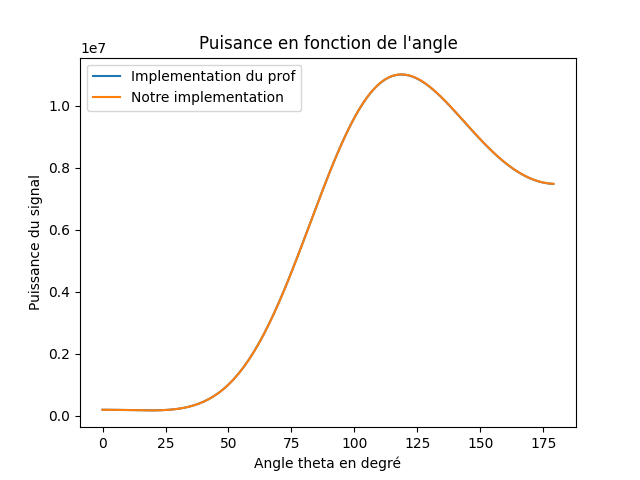

In [20]:
#On vérifie si on obtient la meme chose avec beamformer du prof  pour les questions précédente :
plt.figure()
plt.plot(list(thetas), Puissances, label = "Implementation du prof")
plt.plot(list(thetas), beamforming(m, thetas, 1000, Fs), label = "Notre implementation")
plt.xlabel("Angle theta en degré")
plt.ylabel("Puissance du signal")
plt.title("Puisance en fonction de l'angle")
plt.legend()

plt.show()

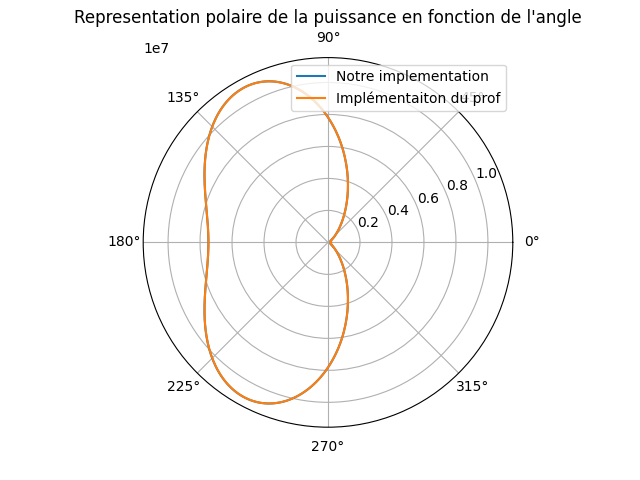

In [21]:
plt.figure()
deg = np.arange(0, 360, 1)
plt.polar(deg*np.pi/180, beamforming(m, deg, 1000, Fs), label = "Notre implementation")
plt.polar(deg*np.pi/180, bf.beamformer(m, deg, 1000, Fs), label = "Implémentaiton du prof")
plt.title("Representation polaire de la puissance en fonction de l'angle")
plt.legend()
plt.show()

On obtient bel est bien la même courbe (avec une très légère différence) dont on ignore la cause, on utilisera alors par la suite notre propre fonction qui semble correcte.

### 13) Plot the energy maps you obtain when using source frequencies F_0 = 400Hz, F_0 = 1kHz, F_0 = 2kHz and F_0 = 4kHz emitting from a fixed arbitrary position. Comment and explain carefully the differences between these curves

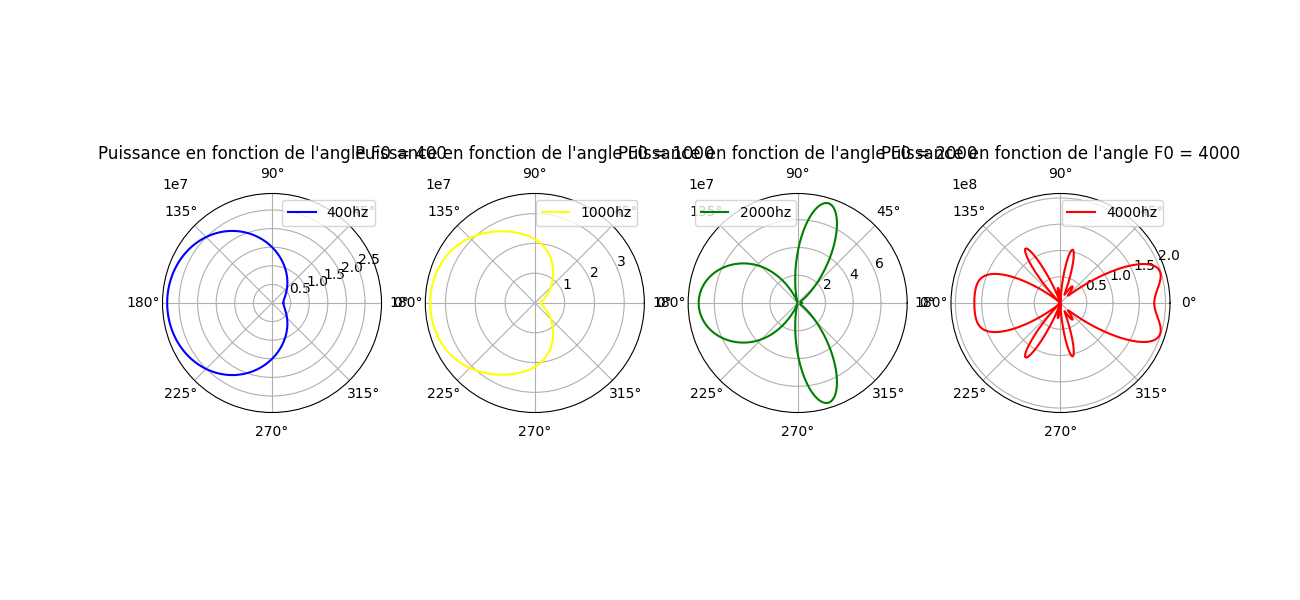

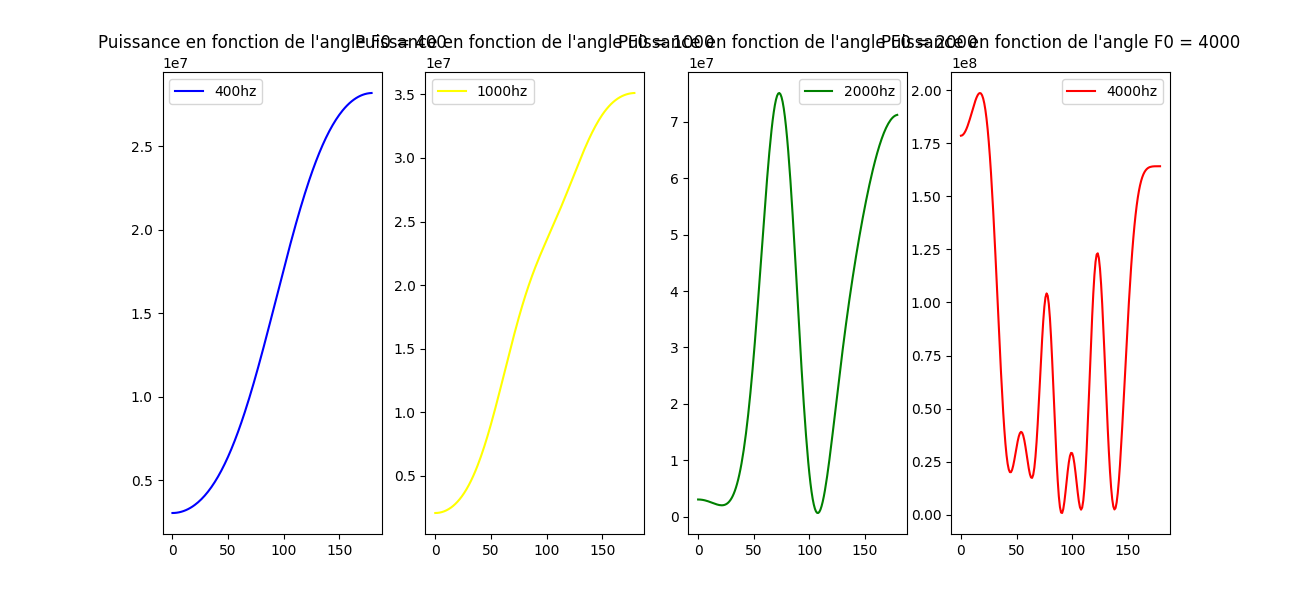

In [22]:
import glob

#Charge tout les fichiers de F0 = 400hz a F0 = 4000hz
paths = glob.glob("Enregistrements/q13/*")
F_tab = []
P_tab = []

thetas = np.arange(0, 360, 1)
for i, p in enumerate(paths):
    indp = p[::-1].index(".")
    ind_ = p[::-1].index("_")
    F0 = p[::-1][indp + 1:ind_]
    F0 = int(F0[::-1])
    F_tab.append(F0)
    m = np.load(p)
    P = beamforming(m, thetas, F0, Fs)
    # P = bf.beamformer(m, thetas, F0, Fs)
    P_tab.append(P)

    # plt.plot(thetas, P, label = f"{F0} hz")

plt.figure(figsize=(13,6))
colors = ['blue', 'yellow', 'green', 'red']
for i in range(len(F_tab)):
    plt.subplot(1,4,i+1, polar = True)
    plt.polar(thetas*np.pi/180, P_tab[i], label = f"{F_tab[i]}hz", color = colors[i])
    plt.title(f"Puissance en fonction de l'angle F0 = {F_tab[i]}")
    plt.legend()

plt.show()

plt.figure(figsize=(13,6))
colors = ['blue', 'yellow', 'green', 'red']
for i in range(len(F_tab)):
    plt.subplot(1,4,i+1)
    plt.plot(thetas[0:180], P_tab[i][0:180], label = f"{F_tab[i]}hz", color = colors[i])
    plt.title(f"Puissance en fonction de l'angle F0 = {F_tab[i]}")
    plt.legend()

plt.show()

Dans cette manipulation, toutes les paramètres (N, L, d ...) sont constant, seul la fréquence varie.  </br>
La sélectivité en angle du beamforming est bien plus petite pour les basses fréquences. On le voit notemment avec la courbe bleu et jaune, la puissance est élevé pour un plus large intervale d'angle theta.  </br>

Pour les plus hautes fréquences , la sélecrivité est de plus en plus forte comme on levoit sur la courube rouge et verte. On peut observer sur la courbe à 4000hz (rouge) et la coube a 2000hz (vert)  des lobes secondaires
par ailleurs 4000Hz ne respecte pas le sampling theoreme, en effet, fmax = $\frac{c}{2d}$ = 28333Hz, et c'est pour sa forme.

### 14) For a frequency F_0 = 1kHz and a source moving aroud the array, plot the estimated position as a function of time. Comment the effectiveness of the approach and its limits.

La case ci dessous sert juste a concaténer le fichier h5. a ne pas executer. </br>

In [23]:
antenne = load_antenne("Enregistrements/turning_record.h5")
m_init = None
m_concat = None #mn-1
i = 0
import time
try: 
    while i < 79:
        m = antenne.read()
        # Il est important de mettre un sleep pour eviter m = None
        time.sleep(0.3)


        if m_init is None:
            m_concat = m.copy()
            m_init = m.copy()
            test = m[0,0]
            continue
        if m is None:
            raise TypeError
        
        # if np.allclose(m, m_init, 1) or m is None:
        #     if m is None:
        #         print("None")
        #     else:
        #         print("egalité")
        #     break

        #L'Enregistrement dur 8s donc, on prendra 79 buffer
        
        m_concat = np.concatenate((m_concat, m), axis = 1)
        i+=1
        print(i,"/", 79)


except KeyboardInterrupt:
    print("fin")

print(m_concat.shape)

{'Enregistrements/turning_record.h5': {'analogs': array([], dtype=float64), 'analogs_number': 0, 'channels_number': 8, 'comment': '', 'compression': False, 'counter': False, 'counter_skip': False, 'dataset_duration': 1, 'dataset_length': 20000, 'dataset_number': 8, 'datatype': 'int32', 'date': '2022-11-21 17:26:59.494968', 'duration': 8, 'mems': array([ 8,  9, 10, 11, 12, 13, 14, 15]), 'mems_number': 8, 'sampling_frequency': 20000.0, 'timestamp': 1669048019.494968}}
1 / 79
2 / 79
3 / 79
4 / 79
5 / 79
6 / 79
7 / 79
8 / 79
9 / 79
10 / 79
11 / 79
12 / 79
13 / 79
14 / 79
15 / 79
16 / 79
17 / 79
18 / 79
19 / 79
20 / 79
21 / 79
22 / 79
23 / 79
24 / 79
25 / 79
26 / 79
27 / 79
28 / 79
29 / 79
30 / 79
31 / 79
32 / 79
33 / 79
34 / 79
35 / 79
36 / 79
37 / 79
38 / 79
39 / 79
40 / 79
41 / 79
42 / 79
43 / 79
44 / 79
45 / 79
46 / 79
47 / 79
48 / 79
49 / 79
50 / 79
51 / 79
52 / 79
53 / 79
54 / 79
55 / 79
56 / 79
57 / 79
58 / 79
59 / 79
60 / 79
61 / 79
62 / 79
63 / 79
64 / 79
65 / 79
66 / 79
67 / 79
68

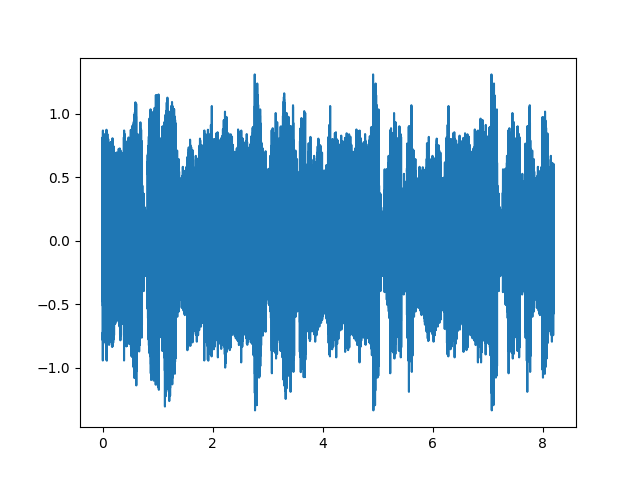

In [24]:
# m_turning = np.load("Enregistrements/turning_q14.npy")
m_turning = m_concat
plt.figure()
t = [i /Fs for i in range(m_turning.shape[1])]
plt.plot(t, m_turning[7])
plt.show()

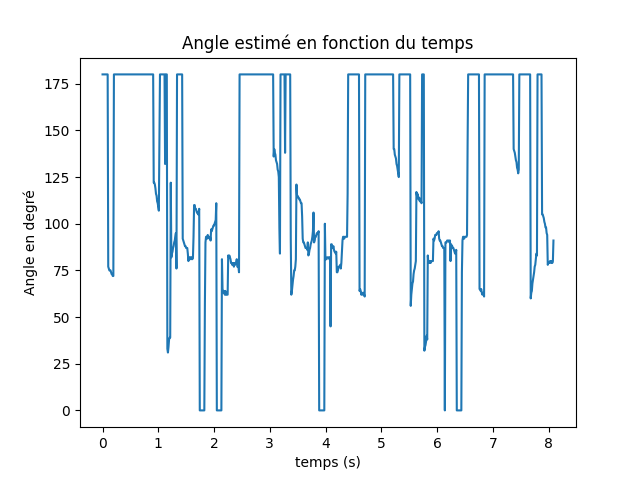

2022-11-22 12:05:10,284 [CRITICAL]: in mu32.log (core_h5.py:252): Unexpected error:sleep length must be non-negative
Traceback (most recent call last):
  File "/media/huss/CE6698AB66989635/Users/tendl/Desktop/M2/Son/TP2/mu32/core_h5.py", line 247, in ctrl_thread
    self.transfer_loop()
  File "/media/huss/CE6698AB66989635/Users/tendl/Desktop/M2/Son/TP2/mu32/core_h5.py", line 475, in transfer_loop
    sleep( self._buffer_duration-time()+time_start-processing_delay )
ValueError: sleep length must be non-negative
2022-11-22 12:05:16,536 [CRITICAL]: in mu32.log (core_h5.py:252): Unexpected error:sleep length must be non-negative
Traceback (most recent call last):
  File "/media/huss/CE6698AB66989635/Users/tendl/Desktop/M2/Son/TP2/mu32/core_h5.py", line 247, in ctrl_thread
    self.transfer_loop()
  File "/media/huss/CE6698AB66989635/Users/tendl/Desktop/M2/Son/TP2/mu32/core_h5.py", line 475, in transfer_loop
    sleep( self._buffer_duration-time()+time_start-processing_delay )
ValueError: 

In [29]:
# A chaque buffer de 2048, on va estimer la position
F0 = 1000
m_turning = np.load("Enregistrements/turning_q14.npy")
k = 0
tab_max = []
t = [] 
pas = BLK //10
thetas = np.arange(0,181, 1)
for i in range(0, m_turning.shape[1] - BLK, pas):
    m = m_turning[:,i:i+pas]
    k+= BLK


    P = beamforming(m, thetas, F0, Fs)
    tab_max.append(np.argmax(P))
    t.append(i/Fs)


plt.figure()
plt.plot(t, tab_max)
plt.xlabel("temps (s)")
plt.ylabel("Angle en degré")
plt.title("Angle estimé en fonction du temps")

plt.show()



Il semblerait que notre enregistrement soit très mauvais